# Ciclo 1 - Classificando Aleatoriamente

Referências para comparação

1. Classificador totalmente aleatório;
2. Aleatório, mas com a mesma distribuição de probabilidade do conjunto de dados;
3. Sempre escolhe a classe mais frequente

In [1]:
import os
import numpy as np
import pandas as pd

import sys
sys.path.append('../')

from machine_learning import ENV, load_obj, plot_dist

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay

import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import Image, display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

folds = 50
n_samples = 10000
np.random.seed = 534


def plot_cm(y_true, y_pred, sorted_classes=(), cmap='Blues', 
            title='Matriz de Confusão', normalized=True, color_bar=False):
    
    sns.set_style("white")
    sns.set_context("notebook")
    
    _cm = confusion_matrix(y_true, y_pred)

    if normalized:
        cm = _cm.astype('float') / _cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = f'{title} (normalizada)'
    else:
        cm = _cm
        fmt = 'd'

    fig = plt.figure(figsize=(20, 20))
    plt.tight_layout()
    plt.ylabel('true area')
    plt.xlabel('predicted area')
    plt.title(title, fontsize=16)

    tick_marks = np.arange(len(sorted_classes))
    plt.xticks(tick_marks, sorted_classes, rotation=45)
    plt.yticks(tick_marks, sorted_classes)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    if color_bar:
        plt.colorbar()

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    filename = f'cm_{title}{ENV["PLT_EXT"]}'.replace(' ', '_').lower()
    filename = os.path.join(ENV['CACHE_FOLDER'], filename)
    fig.savefig(filename, bbox_inches='tight')
    
    plt.show()
    plt.close()


def mean_accuracy(y_true, y_pred):
    return f'{balanced_accuracy_score(y_true, y_pred)*100:.2f}%'


def simulation(y_true, y_pred, title='Simulação', sorted_classes=()):
    print(f'Acurácia média: {mean_accuracy(y_true, y_pred)}')
    print(classification_report(y_true, y_pred, target_names=sorted_classes))
    plot_cm(y_true, y_pred, sorted_classes=sorted_classes, title=title)


## Dados

(363845, 9)

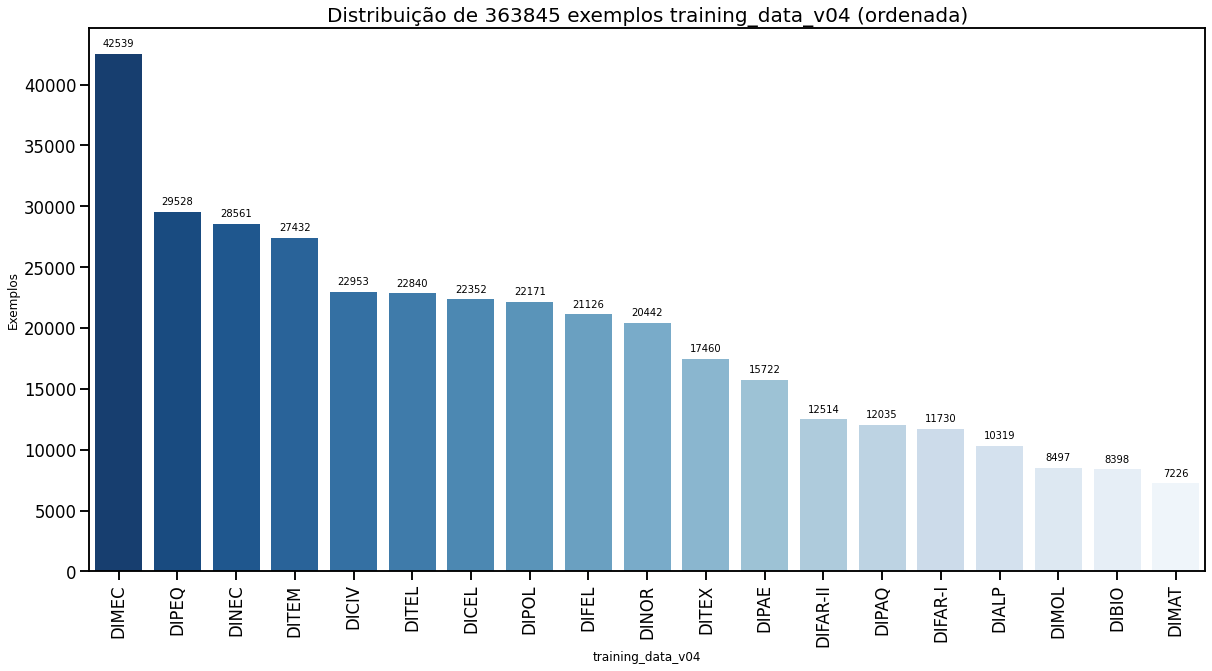

,codigo_interno,numero_inpi,data_deposito,area,techsector,simbolo,ordem,titulo,resumo
count,363845,363845,363845,363845,360738,363845,363845,363845,363845
unique,363845,363845,8316,19,35,207107,10654,347970,363355
top,462220,PI9404437,2014-03-14,DIMEC,14,['A61F 13/15'],['1'],PNEUMÁTICO,"A presente invenção refere-se, geralmente, a f..."
freq,1,1,524,42539,28356,888,161343,116,12


In [2]:
df = pd.read_csv(os.path.join(ENV['OUTPUT_FOLDER'], 'training_data_v04.csv'), 
                 sep=';', encoding='utf-8',
                parse_dates=['data_deposito'],
                dtype={
                    'codigo_interno': str,
                    'numero_inpi': str,
                    'area': str,
                    'techsector': str,
                    'simbolo': str,
                    'ordem': str,
                    'titulo': str,
                    'resumo': str
                })
df = df[df.area!='NOT DEFINED']

probs = pd.Series(df.area).value_counts(normalize=True, ascending=False)
probs = probs.sort_index()

df.shape
status = plot_dist(df['area'], label='training_data_v04', sort=True, palette='Blues_r')
df.describe(include='all')

## Acurácia

Comparação da acurácia de cada classificador, simulando `folds` vezes, `n_samples` exemplos.

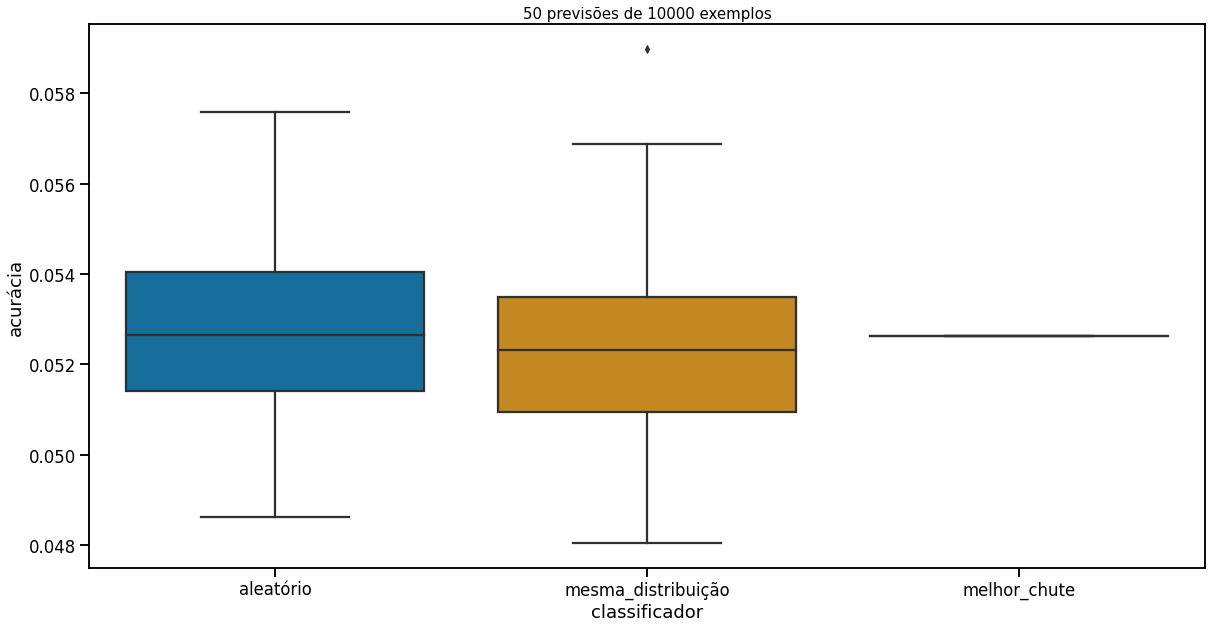

In [3]:
accuracy_history = {
    'classificador': [],
    'acurácia': []
}
filename = os.path.join(ENV['CACHE_FOLDER'], 'comparision_random_choice_classifiers.png')

truth = resample(df.area, n_samples=n_samples, random_state=38)
for fold in range(folds):
    
    random_clf_pred = np.random.choice(probs.index, n_samples)
    same_distribution_clf_pred = np.random.choice(probs.index, n_samples, p=probs)
    best_guess_clf_pred = [probs[probs == probs.max()].index[0]] * n_samples

    accuracy_history['classificador'].append('aleatório')
    accuracy_history['acurácia'].append(balanced_accuracy_score(truth, random_clf_pred))
    accuracy_history['classificador'].append('mesma_distribuição')
    accuracy_history['acurácia'].append(balanced_accuracy_score(truth, same_distribution_clf_pred))
    accuracy_history['classificador'].append('melhor_chute')
    accuracy_history['acurácia'].append(balanced_accuracy_score(truth, best_guess_clf_pred))
history = pd.DataFrame(accuracy_history)

fig = plt.figure(figsize=(20, 10))
g = sns.boxplot(x='classificador', y='acurácia', data=history, palette='colorblind');
plt.title(f'{folds} previsões de {n_samples} exemplos', size=15);
fig.savefig(filename, bbox_inches='tight');

## Matriz de confusão

Uma única simulação com `n_samples` exemplos

### Classificador Aleatório

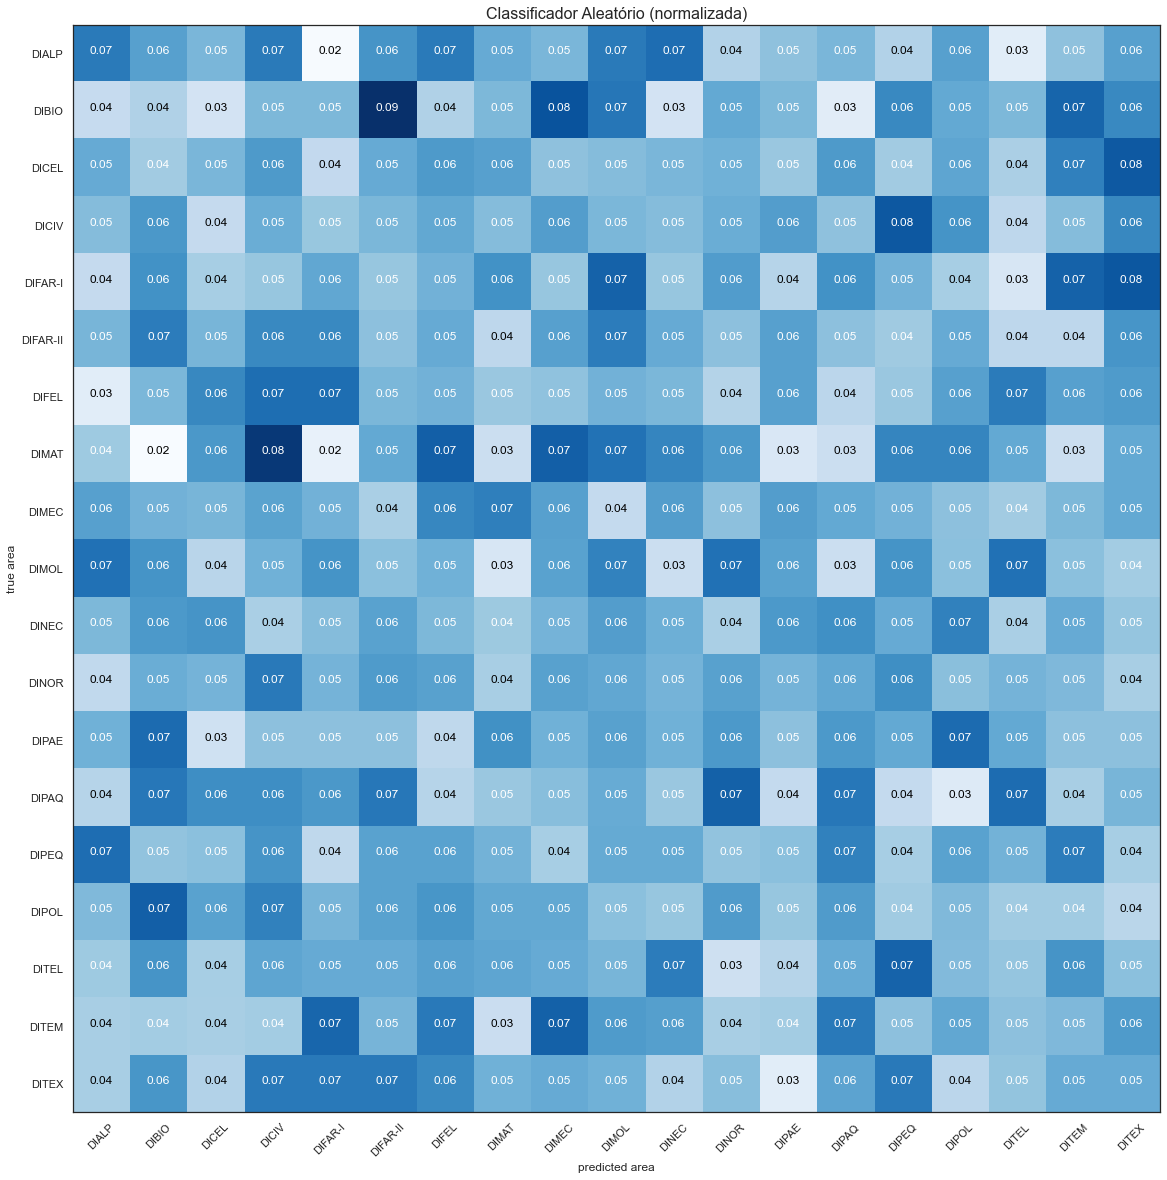

In [4]:
y_true = truth
y_pred = random_clf_pred
title = 'Classificador Aleatório'
simulation(y_true, y_pred, title, sorted_classes=probs.index)

### Classificador Aleatório, com a mesma distribuição de probabilidades

Classificação escolhendo uma classe aleatoriamente, com a mesma distribuição do dataset original

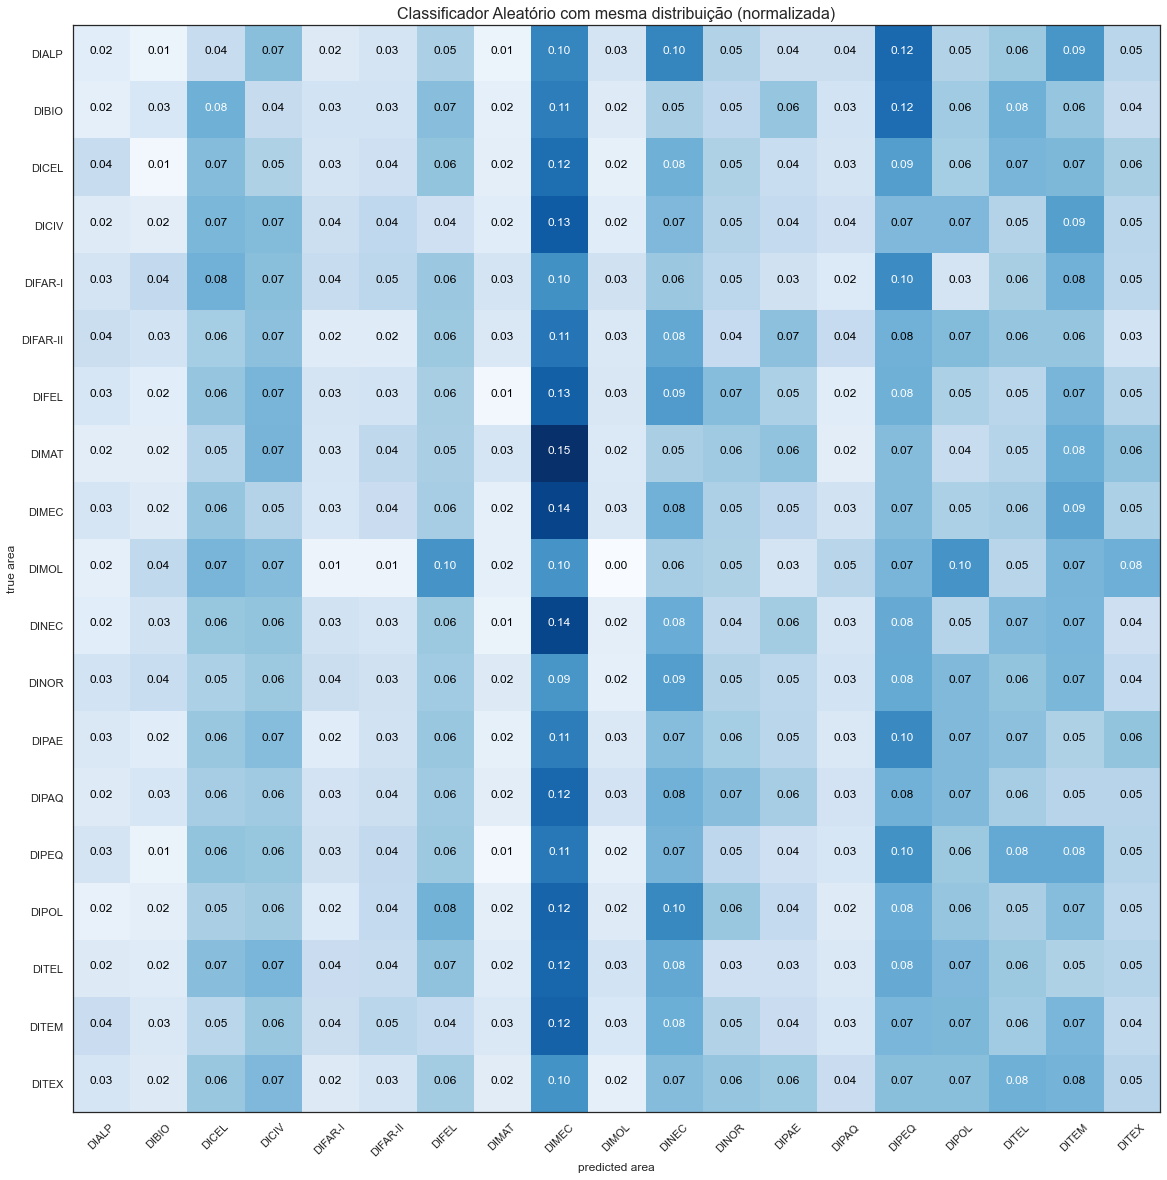

In [5]:
y_true = truth
y_pred = same_distribution_clf_pred
title = 'Classificador Aleatório com mesma distribuição'
simulation(y_true, y_pred, title, sorted_classes=probs.index)

### Escolhendo sempre a classe mais frequente

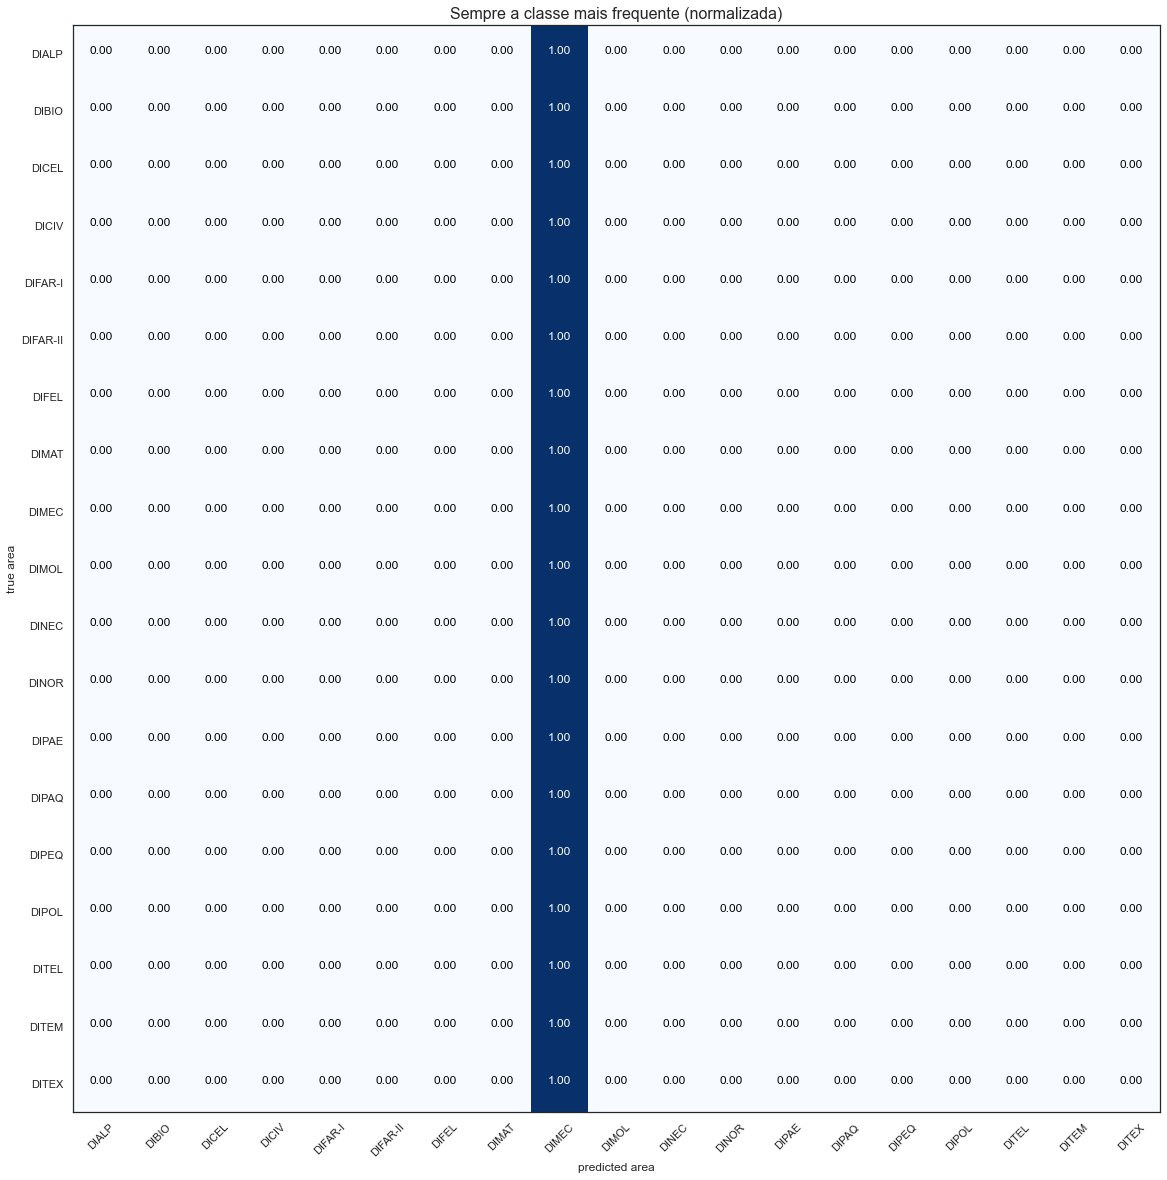

In [6]:
y_true = truth
y_pred = best_guess_clf_pred
title = 'Sempre a classe mais frequente'
simulation(y_true, y_pred, title, sorted_classes=probs.index)